<a href="https://colab.research.google.com/github/joseph7104/-1INF46-Plan_Compras_Produccion/blob/master/notebooks/Benchmark_Inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Modelado y Benchmark de Forecast de Ventas (Prophet corregido)
**Modelos**: SARIMAX, Prophet (corregido), XGBoost, RandomForest  
**Métricas**: MAE, RMSE, MAPE, sMAPE, R², *Forecast Accuracy* (= 1 − MAPE)  
**Gráficos**: Real vs Predicho, residuales, histograma de errores, QQ‑plot, dispersión y comparación en una sola figura.

> Este cuaderno replica el flujo anterior, pero con la sección de **Prophet reforzada** para evitar errores de backend (Stan).


In [1]:
%pip uninstall -y numpy
%pip install numpy==1.26.4

print("Intentando instalar NumPy 1.26.4...")
print("Después de ejecutar esta celda, por favor, REINICIA el entorno de ejecución (Runtime -> Restart runtime) y luego ejecuta las celdas de Prophet nuevamente.")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires num

Intentando instalar NumPy 1.26.4...
Después de ejecutar esta celda, por favor, REINICIA el entorno de ejecución (Runtime -> Restart runtime) y luego ejecuta las celdas de Prophet nuevamente.


In [1]:
%pip uninstall -y fbprophet prophet pystan cmdstanpy
%pip install prophet==1.1.5 cmdstanpy==1.2.0

Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
Found existing installation: cmdstanpy 1.2.0
Uninstalling cmdstanpy-1.2.0:
  Successfully uninstalled cmdstanpy-1.2.0
  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.0-py3-none-any.whl.metadata (3.9 kB)
Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
Using cached cmdstanpy-1.2.0-py3-none-any.whl (93 kB)



## 0) (Opcional) Auto‑Fix Prophet en Colab
Si te falla Prophet por `stan_backend`, ejecuta esta celda sola, **reinicia el runtime** y vuelve a correr desde el inicio.


In [2]:
!git clone https://github.com/joseph7104/-1INF46-Plan_Compras_Produccion.git
%cd "./-1INF46-Plan_Compras_Produccion"

fatal: destination path '-1INF46-Plan_Compras_Produccion' already exists and is not an empty directory.
/content/-1INF46-Plan_Compras_Produccion


## 1) Configuración y librerías

In [3]:
import prophet, cmdstanpy
print("prophet:", prophet.__version__)
print("cmdstanpy:", cmdstanpy.__version__)

# Smoke test mínimo
from prophet import Prophet
import pandas as pd
df_test = pd.DataFrame({
    "ds": pd.date_range("2024-01-01", periods=30, freq="D"),
    "y": range(30)
})
m = Prophet(weekly_seasonality=True)
m.fit(df_test)
print("✅ Prophet funciona correctamente.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxd8xr3mx/m04qmvkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxd8xr3mx/tlmvqmll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77850', 'data', 'file=/tmp/tmpxd8xr3mx/m04qmvkm.json', 'init=/tmp/tmpxd8xr3mx/tlmvqmll.json', 'output', 'file=/tmp/tmpxd8xr3mx/prophet_modelr2z6ybo6/prophet_model-20251031065304.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


prophet: 1.1.5
cmdstanpy: 1.2.0


06:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet funciona correctamente.


In [4]:
# === MODO DE PROPHET ===
# "minimal"  -> corre sí o sí (sin exógenas, como tu benchmark anterior).
# "calendar" -> solo variables de calendario simples (seguro y estable).
# "full"     -> todas las exógenas (lags/clima/etc.); puede fallar si hay NaN/tipos.
PROPHET_MODE = "minimal"  # cambia a "calendar" o "full" cuando lo tengas OK


In [5]:

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# XGBoost (opcional)
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    print("Aviso: XGBoost no disponible. Para instalar: pip install xgboost")

# Statsmodels (SARIMAX)
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# === Ruta del dataset final (ajusta si es necesario) ===
DATA_PATH = Path("data/processed/dataset_forecast_diario.csv")  # <-- Ajusta a tu CSV
DATE_COL = "fecha"

TARGET_CANDIDATES = ["cantidad","ventas","ventas_total","venta_total","y","target","ventas_real"]
FERIADO_CANDIDATES = ["feriado","is_holiday","es_feriado"]
WEEKEND_CANDIDATES = ["fin_de_semana","is_weekend"]
DOW_CANDIDATES = ["dia_semana","dow"]
MONTH_CANDIDATES = ["mes","month"]

SERIES_EXOG_CANDIDATES = [
    "lag_1","lag_7","lag_14","rolling_mean_7","rolling_std_7","rolling_mean_14","rolling_std_14"
]
CLIMATE_CANDIDATES = ["temp_avg","precip_mm","humedad","lluvia_flag","viento_kph"]

print("Ruta dataset:", DATA_PATH)


Ruta dataset: data/processed/dataset_forecast_diario.csv


## 2) Carga del dataset

In [6]:
assert DATA_PATH.exists(), f"No se encontró el archivo en {DATA_PATH}. Ajusta DATA_PATH."
df = pd.read_csv(DATA_PATH)
assert DATE_COL in df.columns, f"No existe la columna de fecha '{DATE_COL}'"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Filtrar datos desde 2023 en adelante
df = df[df[DATE_COL].dt.year >= 2023].copy().reset_index(drop=True)

print("Shape:", df.shape)
df.head(3)

Shape: (12969, 42)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2023-01-01,2,26.0,832.0,2023,1,1,6,1,1,...,20.571429,8.038597,23.500000,7.449832,23.321429,7.060865,-0.781831,0.62349,0.0,1.0
1,2023-01-01,12,6.0,108.0,2023,1,1,6,1,1,...,3.000000,1.732051,2.785714,1.761930,2.964286,1.835497,-0.781831,0.62349,0.0,1.0
2,2023-01-01,5,20.0,500.0,2023,1,1,6,1,1,...,13.857143,4.740906,13.642857,4.617811,14.142857,5.635301,-0.781831,0.62349,0.0,1.0


## 3) Detección de columnas (target y features)

In [7]:

def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = df.columns.tolist()
target_col = pick_col(TARGET_CANDIDATES, cols)
feriado_col = pick_col(FERIADO_CANDIDATES, cols)
weekend_col = pick_col(WEEKEND_CANDIDATES, cols)
dow_col = pick_col(DOW_CANDIDATES, cols) or "dia_semana"
month_col = pick_col(MONTH_CANDIDATES, cols) or "mes"

if dow_col not in df.columns:
    df[dow_col] = df[DATE_COL].dt.dayofweek
if month_col not in df.columns:
    df[month_col] = df[DATE_COL].dt.month
if weekend_col and df[weekend_col].dtype != int:
    df[weekend_col] = pd.to_numeric(df[weekend_col], errors="coerce").fillna(0).astype(int)
if feriado_col and df[feriado_col].dtype != int:
    df[feriado_col] = pd.to_numeric(df[feriado_col], errors="coerce").fillna(0).astype(int)

series_exogs = [c for c in SERIES_EXOG_CANDIDATES if c in cols]
climate_exogs = [c for c in CLIMATE_CANDIDATES if c in cols]

print("Target:", target_col)
print("Feriado:", feriado_col, "| Fin de semana:", weekend_col)
print("Día de semana:", dow_col, "| Mes:", month_col)
print("Exógenas de serie:", series_exogs)
print("Exógenas de clima:", climate_exogs)


Target: cantidad
Feriado: feriado | Fin de semana: fin_de_semana
Día de semana: dow | Mes: mes
Exógenas de serie: ['lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14']
Exógenas de clima: []


## 4) Preparación base y split temporal

In [8]:

assert target_col is not None, "No se detectó la columna objetivo (ventas). Ajusta TARGET_CANDIDATES."

base_exogs = [x for x in [feriado_col, weekend_col, dow_col, month_col] if x is not None]
exog_vars = base_exogs + series_exogs + climate_exogs

df_model = df[[DATE_COL, target_col] + [c for c in exog_vars if c in df.columns]].copy()
df_model = df_model.dropna(subset=[DATE_COL, target_col]).copy()

split_date = df_model[DATE_COL].quantile(0.8)
train = df_model[df_model[DATE_COL] <= split_date].copy()
test  = df_model[df_model[DATE_COL] >  split_date].copy()

y_train, y_test = train[target_col].values, test[target_col].values
X_train = train.drop(columns=[DATE_COL, target_col])
X_test  = test.drop(columns=[DATE_COL, target_col])

print("Train:", train.shape, "| Test:", test.shape)
print("Exógenas finales:", X_train.columns.tolist())


Train: (10383, 13) | Test: (2586, 13)
Exógenas finales: ['feriado', 'fin_de_semana', 'dow', 'mes', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14']


## 5) Métricas y utilitarios

In [9]:

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1e-9
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-9, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mp = mape(y_true, y_pred)
    smp = smape(y_true, y_pred)
    accuracy = 100.0 - mp
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mp, "sMAPE": smp, "Accuracy(1-MAPE)": accuracy}

def plot_predictions(dates, y_true, y_pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(dates, y_true, label="Real")
    plt.plot(dates, y_pred, label="Predicho")
    plt.title(title); plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

def plot_residuals(y_true, y_pred, title_prefix=""):
    resid = y_true - y_pred
    plt.figure(figsize=(10,3))
    plt.plot(resid)
    plt.title(f"{title_prefix} Residuales (y_true - y_pred)")
    plt.xlabel("Índice de observación"); plt.ylabel("Residuo"); plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(resid, bins=20)
    plt.title(f"{title_prefix} Histograma de residuales")
    plt.xlabel("Residuo"); plt.ylabel("Frecuencia"); plt.show()

    plt.figure(figsize=(6,3))
    plt.scatter(y_pred, resid)
    plt.title(f"{title_prefix} Dispersión Predicho vs Residuo")
    plt.xlabel("Predicho"); plt.ylabel("Residuo"); plt.show()

    qqplot(resid, line='s')
    plt.title(f"{title_prefix} QQ-plot residuales")
    plt.show()


## 6) SARIMAX (ARIMA con exógenas)

In [11]:

sarimax_pred = None
try:
    sarimax = sm.tsa.statespace.SARIMAX(
        endog=y_train,
        exog=X_train if len(X_train.columns) else None,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_res = sarimax.fit(disp=False)
    sarimax_forecast = sarimax_res.get_forecast(steps=len(test), exog=X_test if len(X_test.columns) else None)
    sarimax_pred = sarimax_forecast.predicted_mean.values
    print("SARIMAX entrenado.")
except Exception as e:
    print("Error en SARIMAX:", e)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX entrenado.


## 7) Prophet (sección corregida y robusta)

In [10]:
# ---------------- PROPHET ROBUSTO CON MODOS ----------------
prophet_pred = None

# Intentar prophet (nuevo) y si no, fbprophet (legacy)
PROPHET_AVAILABLE = False
try:
    try:
        from prophet import Prophet
        PROPHET_AVAILABLE = True
        PROPHET_FLAVOR = "prophet"
    except Exception:
        from fbprophet import Prophet   # fallback si tu notebook viejo usaba fbprophet
        PROPHET_AVAILABLE = True
        PROPHET_FLAVOR = "fbprophet"
except Exception as e:
    print("No se pudo importar Prophet/fbprophet:", e)
    PROPHET_AVAILABLE = False

def _prep_float(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype(float).fillna(0.0)
    return df

if PROPHET_AVAILABLE:
    try:
        # === Selección de regresores según modo ===
        if PROPHET_MODE == "minimal":
            regressors = []  # sin exógenas (igual que “antes”)
        elif PROPHET_MODE == "calendar":
            # Usa solo calendario (comúnmente robusto)
            base_cands = ["feriado", "fin_de_semana", "dia_semana", "mes"]
            regressors = [c for c in base_cands if c in train.columns]
        else:  # "full"
            regressors = list(X_train.columns)  # todas las de X_train

        # Limpieza de tipos (solo para las columnas elegidas)
        train_pp = _prep_float(train, regressors)
        test_pp  = _prep_float(test, regressors)

        # Prophet exige ds/y
        trp = train_pp.rename(columns={DATE_COL: "ds", target_col: "y"})
        tsp = test_pp.rename(columns={DATE_COL: "ds"})

        # Modelo Prophet con estacionalidad semanal (clave en restaurantes)
        m = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)

        # Añadir regresores (si el modo lo pide)
        for r in regressors:
            # standardize=True para que Prophet escale internamente
            m.add_regressor(r, standardize=True)

        # Ajustar (columnas exactas: "ds","y" + regresores)
        m.fit(trp[["ds","y"] + regressors] if regressors else trp[["ds","y"]])

        # Futuro: mismas columnas y orden
        future = tsp[["ds"] + regressors] if regressors else tsp[["ds"]].copy()
        forecast = m.predict(future)
        prophet_pred = forecast["yhat"].values

        print(f"Prophet entrenado en modo '{PROPHET_MODE}' usando {PROPHET_FLAVOR}.")
    except Exception as e:
        print(f"Error en Prophet (modo={PROPHET_MODE}):", e)
else:
    print("Prophet no disponible; omitiendo este modelo.")
# -----------------------------------------------------------


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxd8xr3mx/p1tj0r64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxd8xr3mx/yl951key.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5653', 'data', 'file=/tmp/tmpxd8xr3mx/p1tj0r64.json', 'init=/tmp/tmpxd8xr3mx/yl951key.json', 'output', 'file=/tmp/tmpxd8xr3mx/prophet_modelq34o2szq/prophet_model-20251031065336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:53:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:53:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet entrenado en modo 'minimal' usando prophet.


## 8) Modelos de árboles (XGBoost y RandomForest)

In [12]:

tree_preds = {}
if len(X_train.columns):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train.values)
    Xte = scaler.transform(X_test.values)

    if XGB_AVAILABLE:
        try:
            xgb = XGBRegressor(
                n_estimators=400, learning_rate=0.05, max_depth=6,
                subsample=0.9, colsample_bytree=0.9, random_state=42
            )
            xgb.fit(Xtr, y_train)
            tree_preds["XGBoost"] = xgb.predict(Xte)
            print("XGBoost entrenado.")
        except Exception as e:
            print("Error en XGBoost:", e)

    try:
        rf = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42)
        rf.fit(Xtr, y_train)
        tree_preds["RandomForest"] = rf.predict(Xte)
        print("RandomForest entrenado.")
    except Exception as e:
        print("Error en RandomForest:", e)
else:
    print("No hay exógenas para modelos de árboles (X_train vacío).")


XGBoost entrenado.
RandomForest entrenado.


## 9) Benchmark de métricas

In [13]:

bench = []

def add_result(name, yhat):
    if yhat is None:
        return
    m = eval_metrics(y_test, yhat)
    row = {"Modelo": name}
    row.update(m)
    bench.append(row)

add_result("SARIMAX", sarimax_pred)
add_result("Prophet", prophet_pred)
for k, v in tree_preds.items():
    add_result(k, v)

df_benchmark = pd.DataFrame(bench).sort_values("MAPE")
df_benchmark.reset_index(drop=True, inplace=True)
df_benchmark


,Modelo,MAE,RMSE,R2,MAPE,sMAPE,Accuracy(1-MAPE)
0,RandomForest,3.283818,4.421877,0.760788,45.210646,33.752195,54.789354
1,XGBoost,3.358320,4.552171,0.746483,45.317114,34.014118,54.682886
2,SARIMAX,3.399232,4.553012,0.746389,50.688627,34.837740,49.311373
3,Prophet,7.316665,8.974750,0.014595,144.649696,66.089515,-44.649696


## 10) Gráficos comparativos y diagnósticos

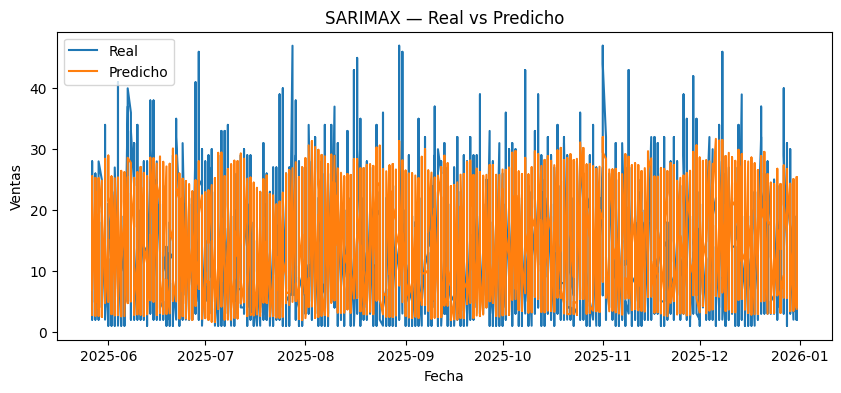

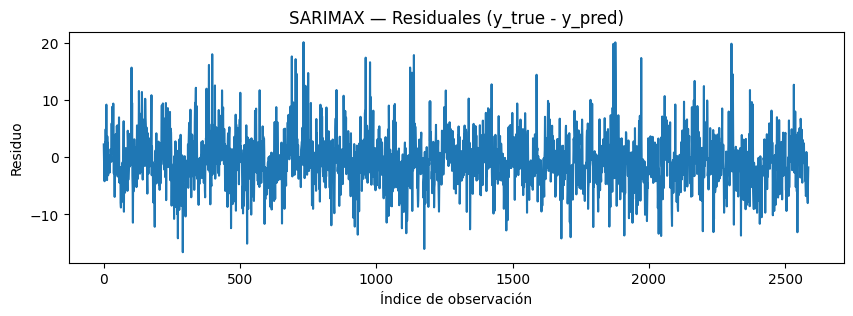

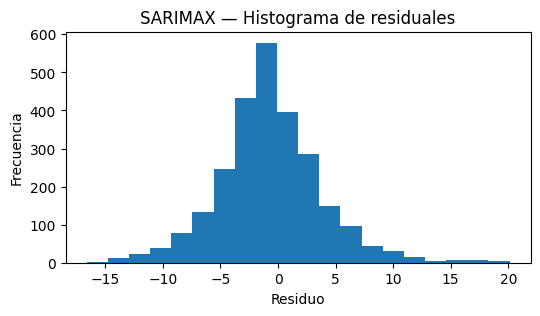

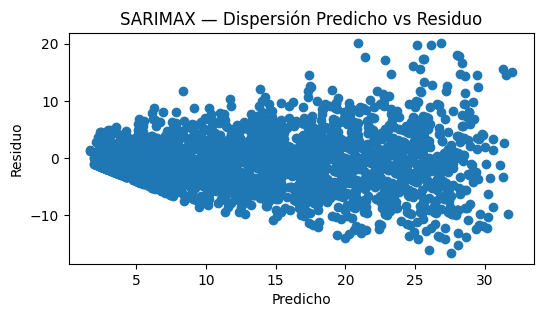

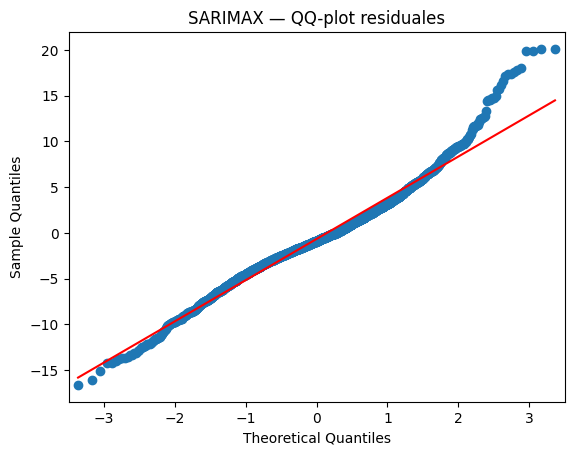

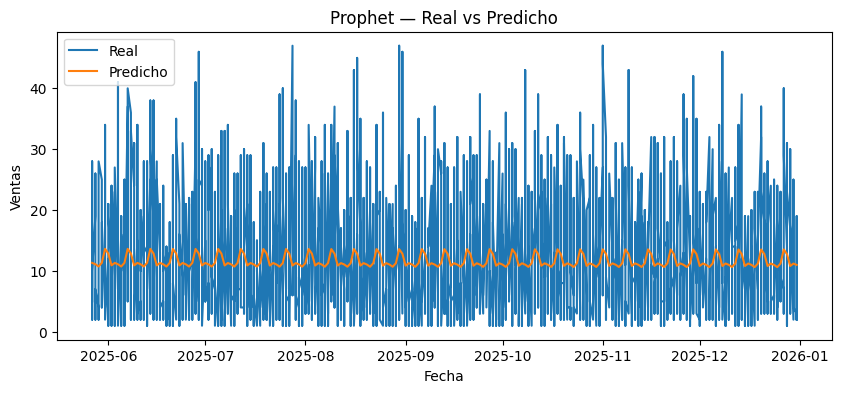

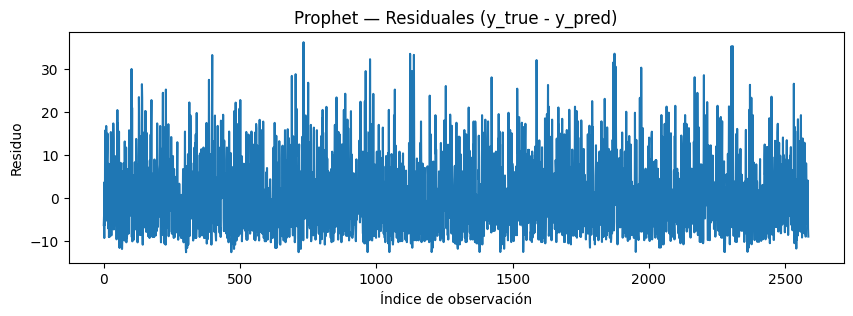

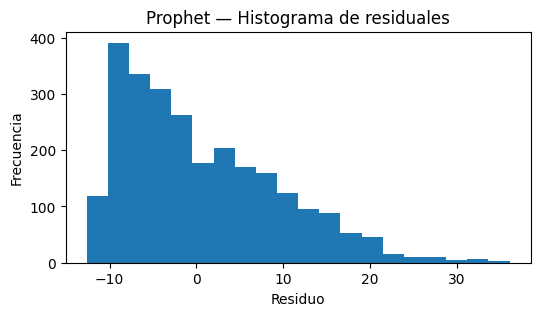

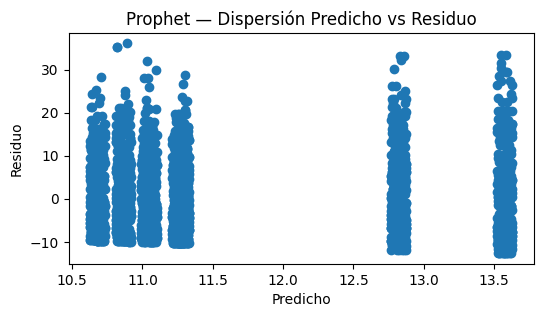

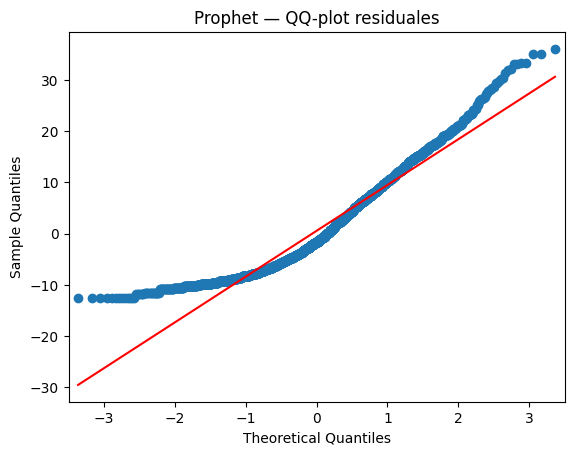

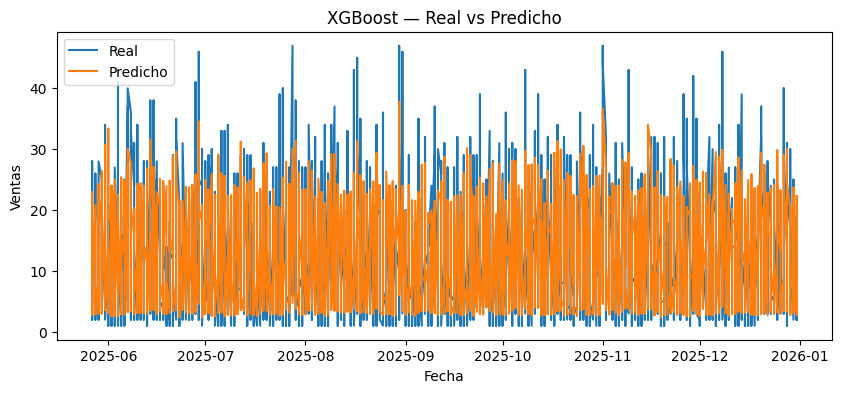

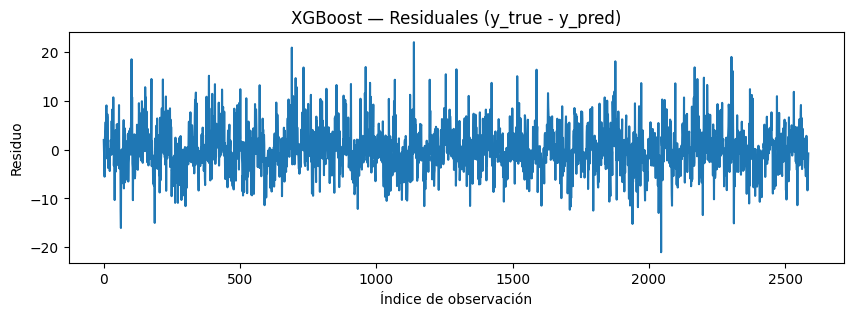

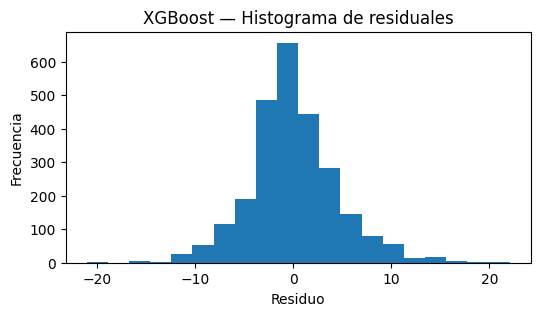

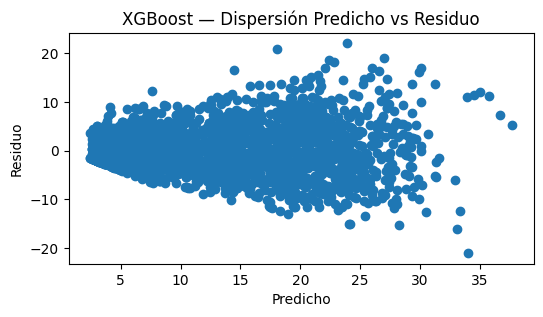

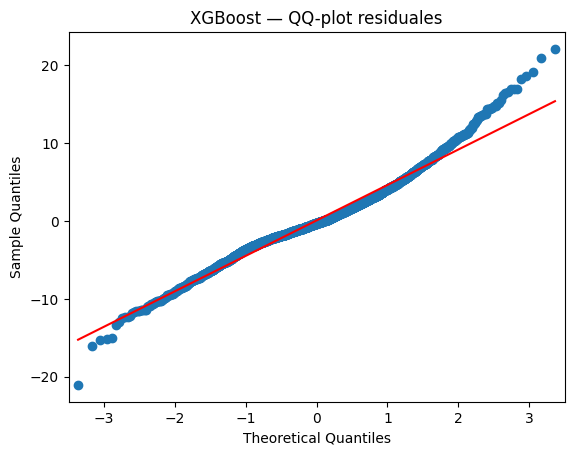

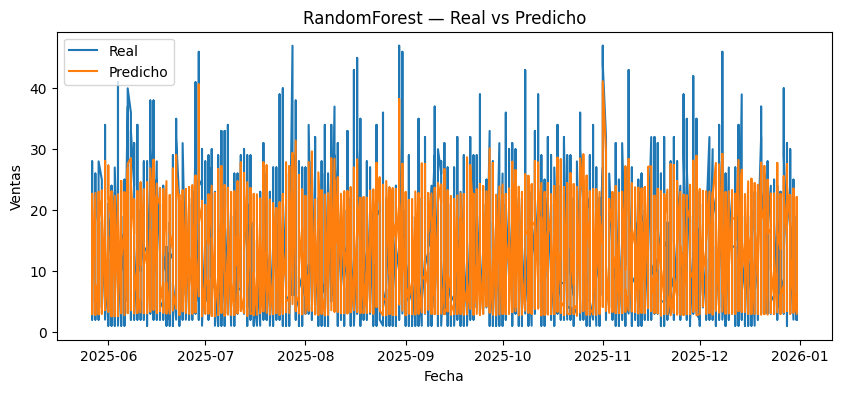

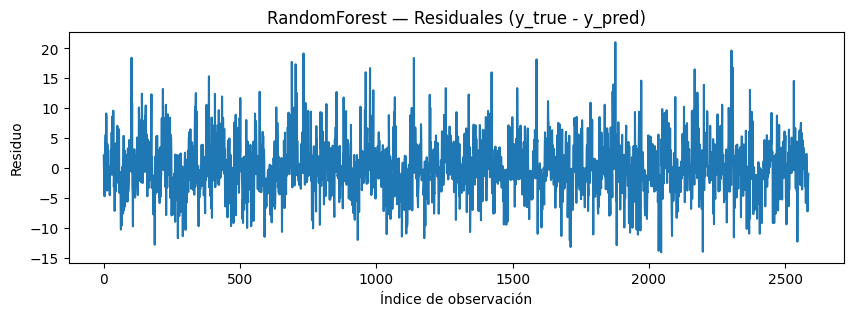

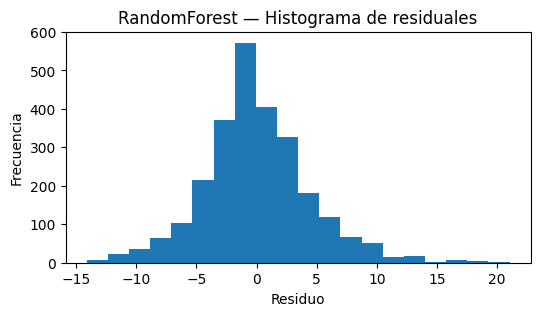

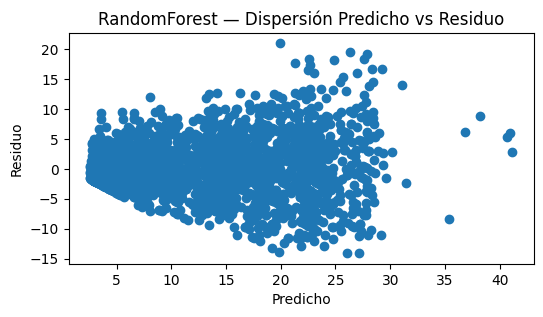

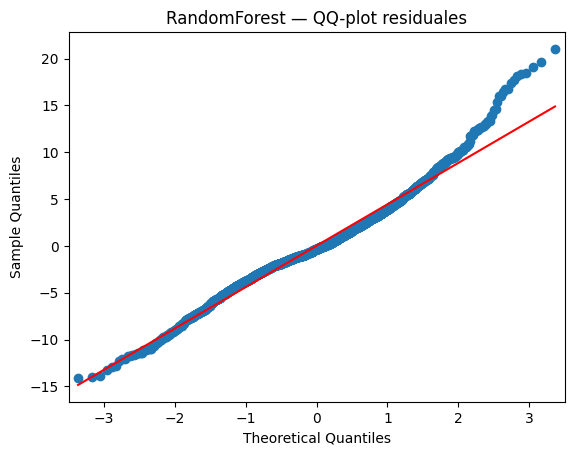

In [14]:

def show_all_plots():
    if sarimax_pred is not None:
        plot_predictions(test[DATE_COL], y_test, sarimax_pred, "SARIMAX — Real vs Predicho")
        plot_residuals(y_test, sarimax_pred, "SARIMAX —")
    if prophet_pred is not None:
        plot_predictions(test[DATE_COL], y_test, prophet_pred, "Prophet — Real vs Predicho")
        plot_residuals(y_test, prophet_pred, "Prophet —")
    for name, pred in tree_preds.items():
        plot_predictions(test[DATE_COL], y_test, pred, f"{name} — Real vs Predicho")
        plot_residuals(y_test, pred, f"{name} —")
show_all_plots()


## 11) Comparación en una sola gráfica

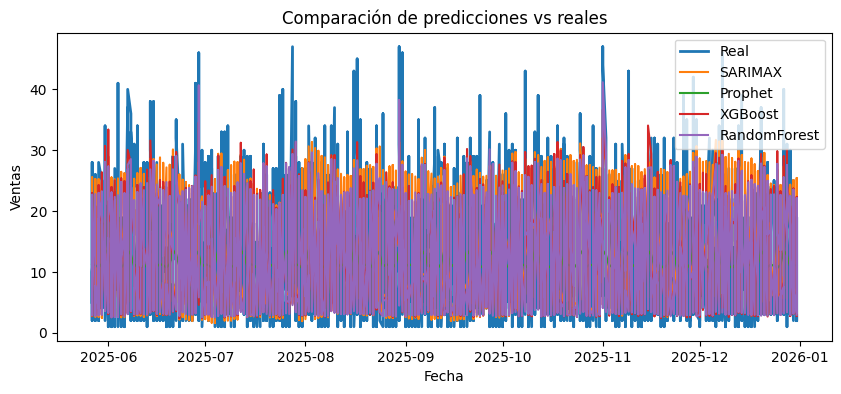

In [15]:

plt.figure(figsize=(10,4))
plt.plot(test[DATE_COL], y_test, label="Real", linewidth=2)

if sarimax_pred is not None:
    plt.plot(test[DATE_COL], sarimax_pred, label="SARIMAX")
if prophet_pred is not None:
    plt.plot(test[DATE_COL], prophet_pred, label="Prophet")
for name, pred in tree_preds.items():
    plt.plot(test[DATE_COL], pred, label=name)

plt.title("Comparación de predicciones vs reales")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()



## 12) Interpretación y selección del modelo
- **MAE / RMSE**: error en magnitud (↓ mejor).
- **MAPE / sMAPE**: error porcentual relativo (↓ mejor).
- **R²**: varianza explicada (↑ mejor).
- **Accuracy (1 − MAPE)**: porcentaje de acierto aproximado para negocio.

**Criterios**: elige el modelo con menor **MAPE/RMSE**, buen **R²** y residuales sin patrón claro.
